In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/Notebooks/Sales Forecasting

/content/drive/My Drive/Notebooks/Sales Forecasting


In [0]:
import pandas as pd
import numpy as np
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [0]:
sales = pd.read_csv('data/sales-of-shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

In [0]:
dates = pd.date_range('1901-01', periods=36, freq='M')
sales.index = dates

1901-01-31    266.0
1901-02-28    145.9
1901-03-31    183.1
1901-04-30    119.3
1901-05-31    180.3
Freq: M, Name: Sales of shampoo over a three year period, dtype: float64


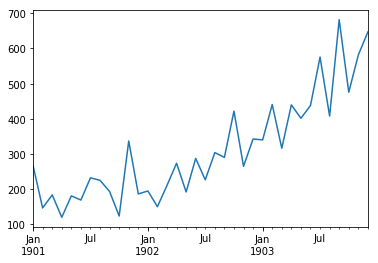

In [0]:
print(sales.head())
sales.plot()
pyplot.show()

As we can see, the data has got an ascending trend and it's composed of 36 observations.

## Autocorrelation plot

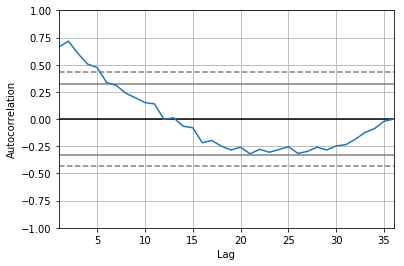

In [0]:
autocorrelation_plot(sales)
pyplot.show()

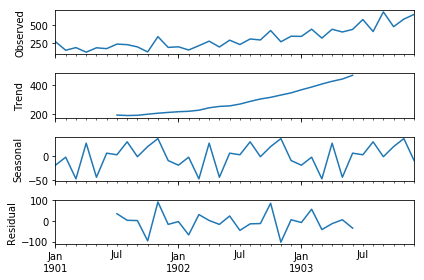

In [0]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(sales).plot()
result = sm.tsa.stattools.adfuller(sales)
pyplot.show()

We can see from the graphs obtained that this dataset follows an increasing trend. 

Hence we can use Holt’s linear trend to forecast the future prices.


## Holt-Winters Double Exponential Smoothing algorithm theory

This algorithm helps us to forecast new observations based on a time series. This algorithm uses smoothing methods. The **Double Exponential Smoothing** algorithm is used only on time series that have a trend. 

On time series that have a trend the **Exponential Smoothing** algorithm does not perform very well. Here you can learn about the exponential smoothing algorithm. This problem was solved by adding a second smoothing constant: **gamma**. 

The mathematical model for this algorithm is:

![Double-Exponential-Smoothing](images/Double-Exponential-Smoothing_updated.png)

where **alpha** is smoothing factor for the level and **beta** is smoothing factor for the trend. They can take values between 0 and 1. 

Ft+m is the forecast at time t, xt is the time series observation at time t, b_t is the trend value at time t. In this case we have to solve two problems:

1. Choosing the values of s_1 and b_1;
2. Choosing the values of alpha and beta.

For the first problem we can choose s_1 to be equal to the first observation and for b_1 we have two common options:

1. we can choose it to be the second observation minus the first (b_1 = x_2 - x_1);
2. we can choose it to be the last observation minus the first, all divided by the total number of observations minus 1 ( b_1 = (x_n - x_1)/(n - 1)).

To solve the second problem we can use the **incremental method**: 

We set the value of alpha (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9) and beta (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), then we calculate the coresponding MSE for each value that alpha and gamma take. After that, we choose the alpha and gamma with the minimum MSE.

After we got the optimal alpha and beta and we have calibrated the trend with the formula presented above we can forecast the next **m** periods of time using the following formula:

## Double Exponential Smoothing implementation

The following section will propose an algorithm for finding the best alpha and beta. 

The algorithm will start at alpha = 0.1 and beta = 01 and will go up to beta = 0.9 then incrementing the alpha to alpha = 0.9. For each alpha and beta, the algorithm will forecast the already known observations along with the correspondent MSE followed by choosing the alpha and beta with the minimum MSE value.

In [45]:
optimal_alpha = None
optimal_beta = None
best_mse = None
db = sales.values.astype('float32')
mean_results_for_all_possible_alpha_beta_values = np.zeros((9, 9))
for beta in range(0, 9):
    for alpha in range(0, 9):
        st = db[0]
        bt = db[1] - db[0]
        mean_for_alpha_beta = np.zeros(len(db))
        mean_for_alpha_beta[0] = np.power(db[0] - st, 2)
        for i in range(1, len(db)):
            temp_pt = ((alpha + 1) * 0.1) * db[i] + (1 - ((alpha + 1) * 0.1)) * (st + bt)
            bt = ((beta + 1) * 0.1) * (temp_pt - st) + (1 - ((beta + 1) * 0.1)) * bt
            st = temp_pt
            mean_for_alpha_beta[i] = np.power(db[i] - st, 2)
        mean_results_for_all_possible_alpha_beta_values[beta][alpha] = np.mean(mean_for_alpha_beta)
        optimal_beta, optimal_alpha = np.unravel_index(
            np.argmin(mean_results_for_all_possible_alpha_beta_values),
            np.shape(mean_results_for_all_possible_alpha_beta_values))
optimal_alpha = (optimal_alpha + 1) * 0.1
optimal_beta = (optimal_beta + 1) * 0.1
best_mse = np.min(mean_results_for_all_possible_alpha_beta_values)
print("Best MSE = %s" % best_mse)
print("Optimal alpha = %s" % optimal_alpha)
print("Optimal beta = %s" % optimal_beta)

Best MSE = 125.81620704283071
Optimal alpha = 0.9
Optimal beta = 0.2


After the optimal **alpha** and **beta** have been found, we can calibrate the trend as following:

In [46]:
st = db[0]
bt = db[1] - db[0]
for i in range(1, len(db)):
    temp_pt = optimal_alpha * db[i] + (1 - optimal_alpha) * (st + bt)
    bt = optimal_beta * (temp_pt - st) + (1 - optimal_beta) * bt
    st = temp_pt
print("P_t = %s" % st)
print("b_t = %s" % bt )

P_t = 641.6334222987338
b_t = 30.033728841040205


Now we can forecast the next **m** periods of time using the formula described above:

In [47]:
print("Next observation = %s" % (st + (1 * bt)))

Next observation = 671.667151139774


## Forecast evaluation

In this section we will compare the forecast data with the real data for the optimal **alpha** and **gamma**

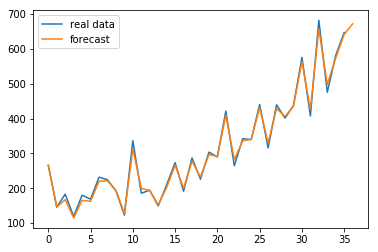

In [48]:
forecast = np.zeros(len(db) + 1)
st = db[0]
bt = db[1] - db[0]
forecast[0] = st
for i in range(1, len(db)):
    temp_pt = optimal_alpha * db[i] + (1 - optimal_alpha) * (st + bt)
    bt = optimal_beta * (temp_pt - st) + (1 - optimal_beta) * bt
    st = temp_pt
    forecast[i] = st
forecast[-1] = st + (1 * bt)
pyplot.plot(db,label = 'real data')
pyplot.plot(forecast, label = 'forecast')
pyplot.legend()
pyplot.show()

As we can see above, the algorithm gives good results on time series that has trend.

In this notebook it was shown how the **Double Exponential Smoothing** algorithm forecasts based on the smoothing constant **alpha** and **beta**. 

Moreover, it was presented an implementation of how you can find the optimal alpha and beta. It was proven that the algorithm gives very good results on time series that have a trend. When dealing with time series, multiple algorithms should be tested to find out which of them gives the minimum MSE. The algorithm with the minimum MSE should be used for further forecasts on that time series.